In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from __future__ import print_function


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# A bunch of utility functions

def show_array_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
def imgshow(array_image):
    """ Show one array image as uint8 and remove axis labels """
    sqrtimg = int(np.ceil(np.sqrt(array_image.shape[0])))
    imshow_noax(array_image.reshape([sqrtimg,sqrtimg]), normalize=True)

def array_to_image(array):
    sqrtimg = int(np.ceil(np.sqrt(array.shape[0])))
    x = np.array(array.reshape([sqrtimg,sqrtimg]))
    return x
    
def image_to_array(image):
    l = image.shape[0]*image.shape[1]
    x = np.array(image.reshape([l]))
    return x

def center_square(array_image, square_h, square_w, pixel_value = 0.45):
    img = array_to_image(array_image)
    h, w = img.shape                     
    j = int(round((h - square_h)/2.))
    i = int(round((w - square_w)/2.))
    img[j:j+square_h, i:i+square_w] = pixel_value
    img = image_to_array(img)
    return img

def mask_images(array_images, masktype, *args):
    """ Retruns an array of image and masked image pairs """
    masked_images = []
    for array_image in array_images:
        if masktype == 'square':
            masked = center_square(array_image,*args)
        masked_images.append(array_image)
        masked_images.append(masked)
    return np.array(masked_images)

#utility functions for GANs

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST', one_hot=False)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
#Training a GAN on MNIST

def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    x_leak = x*alpha
    y = tf.maximum(x, x_leak)
    return y

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Iºnputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    noise = tf.random_uniform([batch_size, dim], minval=-1, maxval=1)
    return noise

def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

In [5]:
#DCGAN generator

def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        z = tf.layers.dense(z, 1024, activation=tf.nn.relu, kernel_initializer=init, name='dense_0')
        z = tf.layers.batch_normalization(z, name='batchnorm_0')
        z = tf.layers.dense(z, 6272, activation=tf.nn.relu, kernel_initializer=init, name='dense_1')
        z = tf.layers.batch_normalization(z, name='batchnorm_1')
        z = tf.reshape(z, [-1, 7, 7, 128])
        z = tf.layers.conv2d_transpose(z, 64, 4, strides=2, padding='same', activation=tf.nn.relu,
                                       kernel_initializer=init, name='conv_0')
        z = tf.layers.batch_normalization(z, name='batchnorm_2')
        z = tf.layers.conv2d_transpose(z, 1, 4, strides=2, padding='same', kernel_initializer=init, 
                                       name='conv_1')
        z = tf.tanh(z)
        img = tf.reshape(z, [-1, 784])
        return img

In [6]:
#WGAN-GP discriminator

def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = tf.layers.conv2d(x, 64, 4, activation=leaky_relu, strides=2, padding='valid',
                             kernel_initializer=init, name='conv_0')
        x = tf.layers.conv2d(x, 128, 4, activation=leaky_relu, strides=2, padding='valid',
                             kernel_initializer=init, name='conv_1')
        #Delete batchnorm for wgan-gp
        #x = tf.layers.batch_normalization(x, name='batchnorm_0')
        x = tf.reshape(x, [-1, 3200])
        x = tf.layers.dense(x, 1024, activation=leaky_relu, kernel_initializer=init,
                            name='dense_0')
        logits = tf.layers.dense(x, 1, kernel_initializer=init, name='logits')
        return logits

In [7]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [8]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.subtract(tf.reduce_mean(logits_fake),tf.reduce_mean(logits_real), name='loss_discriminator')
    G_loss = tf.negative(tf.reduce_mean(logits_fake), name='loss_generator')

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1], minval=0.0, maxval=1.0)
    x_hat = eps*x+(1-eps)*G_sample
    
    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(lam*tf.square(grad_norm-1.0))
    
    D_loss += grad_pen

    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [9]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_array_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_array_images(samples[:16])
    plt.show()

In [10]:
D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [13]:
num_epoch = 120
max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
print(max_iter)

51562


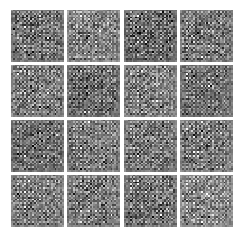


Iter: 0, D: 8.198, G:-0.03958
Iter: 750, D: -1.945, G:1.551


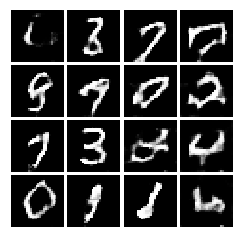


Iter: 1500, D: -0.8885, G:-7.011
Iter: 2250, D: 1.331, G:-10.85


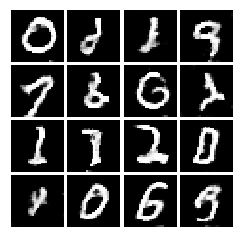


Iter: 3000, D: -0.7923, G:-17.26
Iter: 3750, D: -0.603, G:-26.6


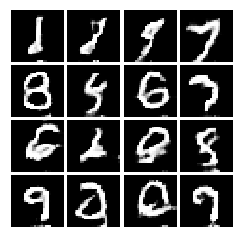


Iter: 4500, D: -0.1665, G:12.68
Iter: 5250, D: -0.6248, G:25.52


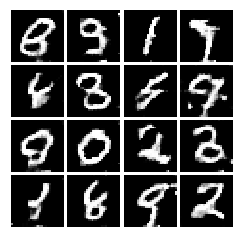


Iter: 6000, D: -0.3406, G:-14.17
Iter: 6750, D: 0.5691, G:-22.22


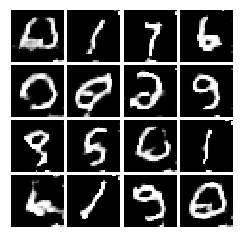


Iter: 7500, D: -0.3699, G:-16.2
Iter: 8250, D: -0.2902, G:8.333


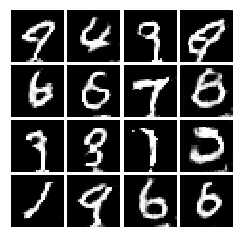


Iter: 9000, D: -1.248, G:-19.12
Iter: 9750, D: 0.2496, G:0.2888


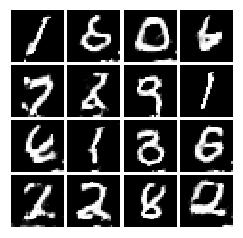


Iter: 10500, D: -0.06418, G:6.757
Iter: 11250, D: 0.3157, G:-11.21


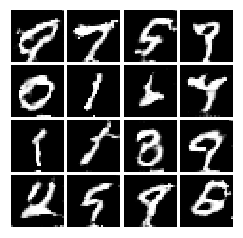


Iter: 12000, D: -0.1894, G:-14.93
Iter: 12750, D: 0.1732, G:16.92


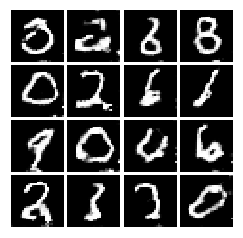


Iter: 13500, D: 0.1994, G:-15.18
Iter: 14250, D: -0.8825, G:-1.458


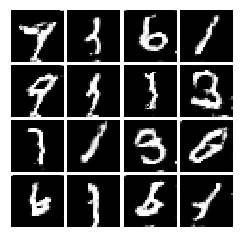


Iter: 15000, D: 0.1225, G:-22.65
Iter: 15750, D: -0.5453, G:11.43


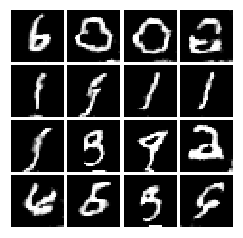


Iter: 16500, D: 0.08673, G:2.016
Iter: 17250, D: 0.05443, G:9.361


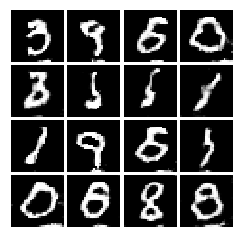


Iter: 18000, D: 0.3363, G:-6.789
Iter: 18750, D: -0.2583, G:4.224


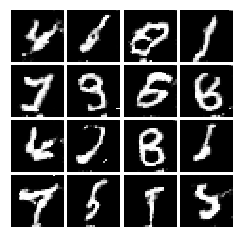


Iter: 19500, D: 0.7794, G:-16.24
Iter: 20250, D: -0.5542, G:-18.5


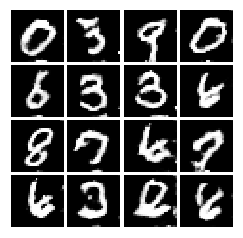


Iter: 21000, D: -0.0712, G:-5.839
Iter: 21750, D: -0.3907, G:-13.29


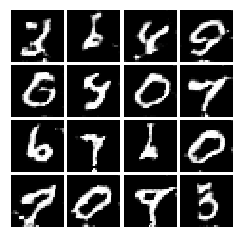


Iter: 22500, D: -0.0496, G:-27.01
Iter: 23250, D: -0.1411, G:-13.75


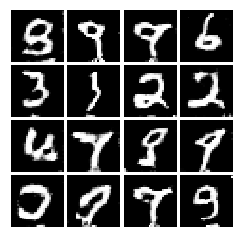


Iter: 24000, D: 0.3644, G:12.02
Iter: 24750, D: -0.713, G:-16.13


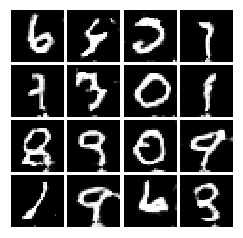


Iter: 25500, D: 0.1166, G:-2.541
Iter: 26250, D: -0.1987, G:14.65


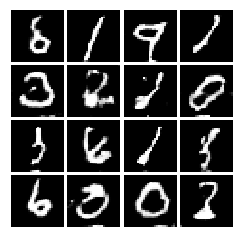


Iter: 27000, D: -0.3822, G:1.419
Iter: 27750, D: 0.2757, G:10.09


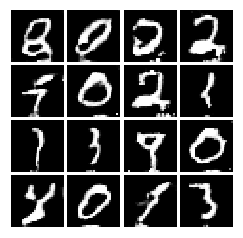


Iter: 28500, D: 0.2121, G:-1.284
Iter: 29250, D: -0.02837, G:1.542


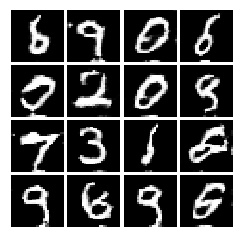


Iter: 30000, D: 0.04159, G:-33.02
Iter: 30750, D: -0.3056, G:19.64


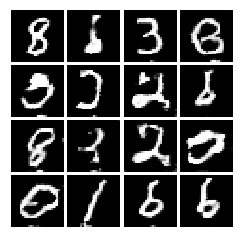


Iter: 31500, D: 0.09265, G:9.515
Iter: 32250, D: -1.368, G:-15.84


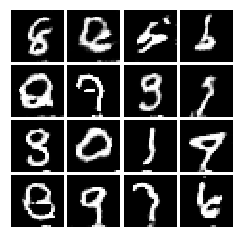


Iter: 33000, D: -0.3505, G:-2.098
Iter: 33750, D: 1.31, G:-2.177


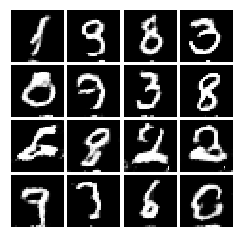


Iter: 34500, D: 0.02316, G:-13.34
Iter: 35250, D: -0.2257, G:-22.81


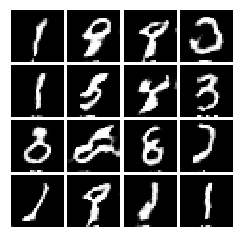


Iter: 36000, D: 0.2381, G:19.63
Iter: 36750, D: -0.05096, G:5.637


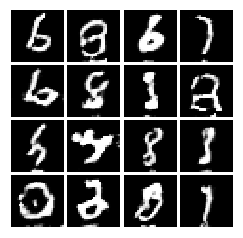


Iter: 37500, D: -0.1877, G:-8.055
Iter: 38250, D: -0.2189, G:-18.79


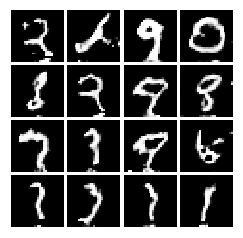


Iter: 39000, D: -0.6017, G:-18.08
Iter: 39750, D: 0.5481, G:9.247


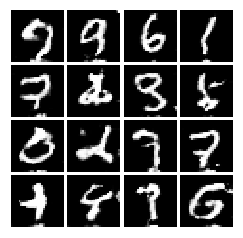


Iter: 40500, D: -0.562, G:-19.39
Iter: 41250, D: -0.1825, G:-8.667


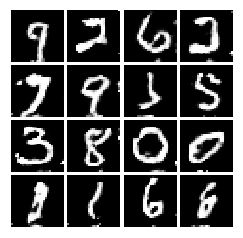


Iter: 42000, D: -0.5691, G:-27.94
Iter: 42750, D: -0.266, G:-4.289


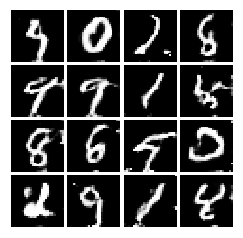


Iter: 43500, D: -0.2587, G:5.69
Iter: 44250, D: -0.3936, G:-3.111


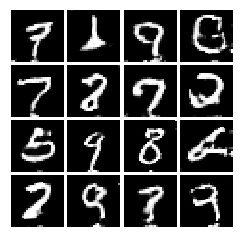


Iter: 45000, D: 0.1442, G:-8.816
Iter: 45750, D: -0.4108, G:-1.361


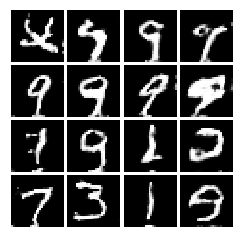


Iter: 46500, D: 0.1811, G:-4.652
Iter: 47250, D: -0.02346, G:8.667


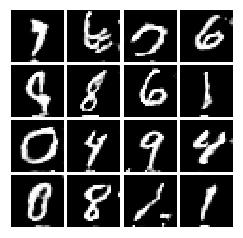


Iter: 48000, D: 0.1012, G:0.4229
Iter: 48750, D: 0.7637, G:-8.069


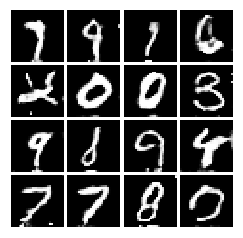


Iter: 49500, D: -0.4254, G:-8.806
Iter: 50250, D: -0.2831, G:-1.203


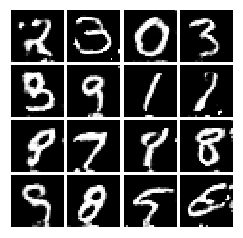


Iter: 51000, D: -0.05061, G:3.096
Final images


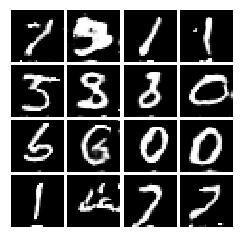

Model saved in file: ../models/mnist_wgangp/mnist_wgangp.ckpt


In [14]:
saver = tf.train.Saver()
g = tf.get_default_graph()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step, num_epoch=120, 
             print_every= 750, show_every = 1500)
    save_path = saver.save(sess, "../models/mnist_wgangp/mnist_wgangp.ckpt")
    print("Model saved in file: %s" % save_path)

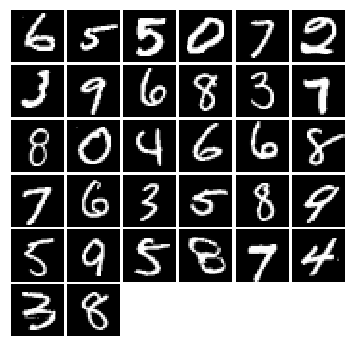

In [51]:
# show a batch
show_array_images(mnist.train.next_batch(32)[0])